In [1]:
import os

# Importing the libraries
import xgboost
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

from IPython.display import display, Image
import warnings

warnings.filterwarnings("ignore")


In [4]:
# Importing the dataset
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

data = pd.read_csv("House Price/train.csv")
display(data)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [5]:
# Tìm tên cột, số lượng và phần trăm các giá trị bị thiếu
def find_missing_percent(data):
    miss_df = pd.DataFrame(columns=["ColumnName", "TotalMissingVals", "PercentMissing"])

    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val / data.shape[0]) * 100, 2)
        # Add to the Missing dataframe if there are missing values
        if sum_miss_val > 0:
            missinginfo = {
                "ColumnName": col,
                "TotalMissingVals": sum_miss_val,
                "PercentMissing": percent_miss_val,
            }
            miss_df = miss_df.append(missinginfo, ignore_index=True)
    miss_df = miss_df.reset_index(drop=True)
    return miss_df


In [6]:
# Data Exploration: Missing Values
miss_df = find_missing_percent(data)
print(f"Number of columns with missing values: {miss_df.shape}")
display(miss_df)


Number of columns with missing values: (19, 3)


,ColumnName,TotalMissingVals,PercentMissing
0,LotFrontage,259,17.74
1,Alley,1369,93.77
2,MasVnrType,8,0.55
3,MasVnrArea,8,0.55
4,BsmtQual,37,2.53
5,BsmtCond,37,2.53
6,BsmtExposure,38,2.60
7,BsmtFinType1,37,2.53
8,BsmtFinType2,38,2.60
9,Electrical,1,0.07


## Delete Columns Missing Values > 50%


In [7]:
# Delete Columns Missing Values > 50%
drop_cols = miss_df[miss_df["PercentMissing"] > 50.0].ColumnName.tolist()
print(f"Column to drop {drop_cols}")
data = data.drop(drop_cols, axis=1)

display(data.head())
print(data.shape)


Column to drop ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


(1460, 77)


In [8]:
# Data Exploring : Missing Values
miss_df = find_missing_percent(data)
print(f"Number of columns with missing values: {miss_df.shape}")
miss_features = miss_df["ColumnName"].values
display(miss_df)
print(f"Total Missing Features {miss_features}")


Number of columns with missing values: (15, 3)


,ColumnName,TotalMissingVals,PercentMissing
0,LotFrontage,259,17.74
1,MasVnrType,8,0.55
2,MasVnrArea,8,0.55
3,BsmtQual,37,2.53
4,BsmtCond,37,2.53
5,BsmtExposure,38,2.60
6,BsmtFinType1,37,2.53
7,BsmtFinType2,38,2.60
8,Electrical,1,0.07
9,FireplaceQu,690,47.26


Total Missing Features ['LotFrontage' 'MasVnrType' 'MasVnrArea' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Electrical' 'FireplaceQu'
 'GarageType' 'GarageYrBlt' 'GarageFinish' 'GarageQual' 'GarageCond']


---


## Delete Row Missing Values


In [10]:
# Data Cleansing: Partial Deletion - Listwise Deletion

# Delete Row Missing Values
def listwise_deletion(data):
    for col in data.columns:
        miss_ind = data[col][data[col].isnull()].index
        data = data.drop(miss_ind, axis=0)
    data = data.reset_index(drop=True)
    return data


In [11]:
raw_data = data.copy()
data_deletion = listwise_deletion(raw_data)
print(data_deletion.shape)
display(data.shape)
display(data_deletion.head())

# test missing again
print("Missing Value Statistics :")
display(find_missing_percent(data_deletion))


(583, 77)


(1460, 77)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
1,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
2,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
3,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
4,7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000


Missing Value Statistics :


,ColumnName,TotalMissingVals,PercentMissing


---


## Thay missing bằng Mean and Mode


In [13]:
# Mean and Mode Imputation
numeric_cols = data.select_dtypes(["float", "int"]).columns
categoric_cols = data.select_dtypes("object").columns

print(numeric_cols)
print(categoric_cols)


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC

In [14]:
# Data Cleansing: Mean and Mode Imputation
# numeric_col: all numeric columns
# categorical_col: all categorical columns
# missing_cols: all columns with missing values
def mean_imputation(data_numeric):
    """
    Mean Imputation
    """
    for col in data_numeric.columns:
        mean = data_numeric[col].mean()
        data_numeric[col] = data_numeric[col].fillna(mean)
    return data_numeric


def mode_imputation(data_categoric):
    """
    Mode Imputation
    """
    for col in data_categoric.columns:
        mode = data_categoric[col].mode().iloc[0]
        data_categoric[col] = data_categoric[col].fillna(mode)
    return data_categoric


In [15]:
data_raw = data.copy()
data_numeric_mean_imp = mean_imputation(data_raw[numeric_cols])
display(data_numeric_mean_imp.head())
print(data_numeric_mean_imp.shape)

print("Missing Value Statistics of Numeric Features :")
display(find_missing_percent(data_numeric_mean_imp))


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


(1460, 38)
Missing Value Statistics of Numeric Features :


,ColumnName,TotalMissingVals,PercentMissing


In [16]:
data_categoric_mode_imp = mode_imputation(data_raw[categoric_cols])
display(data_categoric_mode_imp.head())
print(data_categoric_mode_imp.shape)

print("Missing Value Statistics of Categorical Features :")
display(find_missing_percent(data_categoric_mode_imp))


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


(1460, 39)
Missing Value Statistics of Categorical Features :


,ColumnName,TotalMissingVals,PercentMissing


In [17]:
# Data Cleansing and Partition (Data Imputation - Mean and Mode Imputation)
data_imputed = pd.concat([data_numeric_mean_imp, data_categoric_mode_imp], axis=1)

display(data_imputed.head())
print(data_imputed.shape)

print("Missing Value Statistics of Category and Numeric Features :")
display(find_missing_percent(data_imputed))


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


(1460, 77)
Missing Value Statistics of Category and Numeric Features :


,ColumnName,TotalMissingVals,PercentMissing


---


## Dự đoán missing values bằng mô hình regression


In [19]:
"""
Dự đoán missing values bằng mô hình regression
Từ X (các cột full dữ liệu) dự đoán Y (Cột thiếu) => ra mô hình regression => quay lại dự đoán Y chỗ bị (missing values)
Bài này:
với cột loại sẽ dụng mde để thay thế
cột số sẽ dùng mô hình máy học để dự đoán
"""


'\nDự đoán missing values bằng mô hình regression\nTừ X (các cột full dữ liệu) dự đoán Y (Cột thiếu) => ra mô hình regression => quay lại dự đoán Y chỗ bị (missing values)\nBài này:\nvới cột loại sẽ dụng mde để thay thế\ncột số sẽ dùng mô hình máy học để dự đoán\n'

In [20]:
data_raw = data.copy()

missing_numeric_cols = list(set(miss_features) - set(categoric_cols))
missing_categoric_cols = list(set(miss_features) - set(numeric_cols))

target_cols = missing_numeric_cols
predictor_cols = list(set(numeric_cols) - set(target_cols) - set(["Id"]))
print("predictors: ", predictor_cols)
print("targets: ", target_cols)


predictors:  ['YearBuilt', 'LotArea', 'KitchenAbvGr', 'TotRmsAbvGrd', '3SsnPorch', 'BsmtFinSF2', 'MiscVal', 'OverallQual', 'EnclosedPorch', 'BedroomAbvGr', 'YrSold', 'SalePrice', 'BsmtHalfBath', 'MSSubClass', 'ScreenPorch', 'HalfBath', 'OpenPorchSF', 'OverallCond', 'MoSold', 'GarageCars', 'GrLivArea', 'YearRemodAdd', 'LowQualFinSF', 'BsmtFullBath', 'GarageArea', 'TotalBsmtSF', 'Fireplaces', '1stFlrSF', 'FullBath', 'BsmtFinSF1', 'WoodDeckSF', 'PoolArea', 'BsmtUnfSF', '2ndFlrSF']
targets:  ['MasVnrArea', 'LotFrontage', 'GarageYrBlt']


In [21]:
def model_Imputation(data, target_cols, predictors_cols):
    data_imputation_reg = data
    data_numeric_predictor = data[predictors_cols]
    for col in target_cols:
        # X là các cột trong predictors_cols
        # y là cột chứa missing values cần dự đoán, NHƯNG TRONG y VẪN CÓ NHỮNG GIÁ TRỊ NaN

        # Remove NaN in y
        miss_ind = data_imputation_reg[col][data_imputation_reg[col].isnull()].index
        X = data_numeric_predictor.values
        y = data_imputation_reg[col].values
        X_drop = np.delete(X, miss_ind, axis=0)
        y_drop = np.delete(y, miss_ind, axis=0)

        # # Train model
        xgb = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
        xgb.fit(X_drop, y_drop)

        # Predict missing values
        X_miss = data_imputation_reg[predictor_cols].iloc[miss_ind].values
        y_pred = xgb.predict(X_miss)
        data_imputation_reg[col].iloc[miss_ind] = y_pred

    return data_imputation_reg


In [22]:
data_imputation_numerics_reg = model_Imputation(data_raw, target_cols, predictor_cols)
# drop columns in missing_categoric_cols
data_imputation_numerics_reg = data_imputation_numerics_reg.drop(
    missing_categoric_cols, axis=1
)

data_imputation_missing_categoric_cols = mode_imputation(
    data_raw[missing_categoric_cols]
)

# concat data
data_imputation_reg = pd.concat(
    [data_imputation_numerics_reg, data_imputation_missing_categoric_cols], axis=1
)
display(data_imputation_reg)

miss_df = find_missing_percent(data_imputation_reg)
display(miss_df)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MasVnrType,BsmtExposure,BsmtQual,BsmtCond,GarageType,GarageFinish,Electrical,FireplaceQu,GarageQual,GarageCond,BsmtFinType1,BsmtFinType2
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2003.0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,BrkFace,No,Gd,TA,Attchd,RFn,SBrkr,Gd,TA,TA,GLQ,Unf
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,1976.0,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,None,Gd,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,ALQ,Unf
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2001.0,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,BrkFace,Mn,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,GLQ,Unf
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,1998.0,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,None,No,TA,Gd,Detchd,Unf,SBrkr,Gd,TA,TA,ALQ,Unf
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,2000.0,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,BrkFace,Av,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,GLQ,Unf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,1999.0,2,460,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,None,No,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,Unf,Unf
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,119.0,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,1978.0,2,500,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,Stone,No,Gd,TA,Attchd,Unf,SBrkr,TA,TA,TA,ALQ,Rec
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,0.0,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,1941.0,1,252,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,None,No,TA,Gd,Attchd,RFn,SBrkr,Gd,TA,TA,GLQ,Unf
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,1950.0,1,240,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,None,Mn,TA,TA,Attchd,Unf,FuseA,Gd,TA,TA,GLQ,Rec


,ColumnName,TotalMissingVals,PercentMissing


---


In [24]:
raw_data = data.copy()

data_numeric = raw_data[numeric_cols]
# check null
display(find_missing_percent(data_numeric))


# MICE
# MICE Numeric
inter_imputer_numeric = IterativeImputer(GradientBoostingRegressor())
data_numeric_imputation_mice = inter_imputer_numeric.fit_transform(data_numeric)
# array to dataframe
df_numeric_imputation_mice = pd.DataFrame(
    data_numeric_imputation_mice, columns=data_numeric.columns
)
display(df_numeric_imputation_mice)

# check null
display(find_missing_percent(df_numeric_imputation_mice))


,ColumnName,TotalMissingVals,PercentMissing
0,LotFrontage,259,17.74
1,MasVnrArea,8,0.55
2,GarageYrBlt,81,5.55


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,1.0,1999.0,2.0,460.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,175000.0
1456,1457.0,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,7.0,2.0,1978.0,2.0,500.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,210000.0
1457,1458.0,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,1188.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,9.0,2.0,1941.0,1.0,252.0,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,266500.0
1458,1459.0,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,0.0,1078.0,1078.0,0.0,0.0,1078.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1950.0,1.0,240.0,366.0,0.0,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,142125.0


,ColumnName,TotalMissingVals,PercentMissing


In [25]:
data_categoric = raw_data[categoric_cols]

# Encoding Categoric
encoder = {}
for col in data_categoric.columns:
    encoder[col] = OrdinalEncoder()
    data_categoric[col][data_categoric[col].notnull()] = encoder[col].fit_transform(
        data_categoric[col][data_categoric[col].notnull()].values.reshape(-1, 1)
    )

# check null
display(find_missing_percent(data_categoric))
display(data_categoric.shape)

# MICE Categoric
# max_iter=5: lặp lại 5 lần. nếu ko để thì iputer đến khi nào đúng nhất
# initial_strategy='most_frequent' nếu ko có giá trị (Nan) thì sẽ gán giá trị xuất hiện nhiều nhất
inter_imputer_categoric = IterativeImputer(GradientBoostingRegressor())
data_categoric_imputation_mice = inter_imputer_categoric.fit_transform(data_categoric)
# array to dataframe
df_categoric_imputation_mice = pd.DataFrame(
    data_categoric_imputation_mice, columns=data_categoric.columns
)
# check null
display(df_categoric_imputation_mice)
display(find_missing_percent(df_categoric_imputation_mice))


,ColumnName,TotalMissingVals,PercentMissing
0,MasVnrType,8,0.55
1,BsmtQual,37,2.53
2,BsmtCond,37,2.53
3,BsmtExposure,38,2.60
4,BsmtFinType1,37,2.53
5,BsmtFinType2,38,2.60
6,Electrical,1,0.07
7,FireplaceQu,690,47.26
8,GarageType,81,5.55
9,GarageFinish,81,5.55


(1460, 39)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,2.825658,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,1.0,1.0,8.0,8.0,2.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,5.0,1.0,0.0,1.0,4.0,3.0,6.0,4.000000,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,2.000000,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,15.0,2.0,3.0,4.0,0.0,3.0,1.0,3.0,0.0,5.0,1.0,2.0,1.0,4.0,2.0,6.0,4.000000,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,3.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,1.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,5.0,1.0,0.0,1.0,4.0,2.0,6.0,2.000000,1.0,1.0,4.0,4.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3.0,1.0,3.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,2.0,3.0,4.0,2.0,3.0,3.0,3.0,4.0,5.0,1.0,0.0,1.0,4.0,3.0,6.0,0.000000,5.0,2.0,4.0,4.0,2.0,8.0,4.0
1456,3.0,1.0,3.0,3.0,0.0,4.0,0.0,14.0,2.0,2.0,0.0,2.0,1.0,1.0,9.0,10.0,1.0,3.0,4.0,1.0,0.0,3.0,0.0,2.0,5.0,1.0,4.0,1.0,4.0,3.0,2.0,2.000000,1.0,0.0,4.0,4.0,2.0,8.0,4.0
1457,3.0,1.0,3.0,3.0,0.0,4.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,5.0,5.0,2.0,0.0,2.0,4.0,0.0,3.0,3.0,5.0,5.0,1.0,0.0,1.0,0.0,2.0,6.0,4.000000,1.0,0.0,4.0,4.0,2.0,8.0,4.0
1458,3.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,2.0,2.0,0.0,2.0,3.0,1.0,8.0,8.0,3.0,3.0,4.0,1.0,2.0,3.0,3.0,5.0,5.0,1.0,2.0,1.0,4.0,2.0,6.0,2.706977,1.0,1.0,4.0,4.0,2.0,8.0,4.0


,ColumnName,TotalMissingVals,PercentMissing


In [26]:
encoder


{'MSZoning': OrdinalEncoder(),
 'Street': OrdinalEncoder(),
 'LotShape': OrdinalEncoder(),
 'LandContour': OrdinalEncoder(),
 'Utilities': OrdinalEncoder(),
 'LotConfig': OrdinalEncoder(),
 'LandSlope': OrdinalEncoder(),
 'Neighborhood': OrdinalEncoder(),
 'Condition1': OrdinalEncoder(),
 'Condition2': OrdinalEncoder(),
 'BldgType': OrdinalEncoder(),
 'HouseStyle': OrdinalEncoder(),
 'RoofStyle': OrdinalEncoder(),
 'RoofMatl': OrdinalEncoder(),
 'Exterior1st': OrdinalEncoder(),
 'Exterior2nd': OrdinalEncoder(),
 'MasVnrType': OrdinalEncoder(),
 'ExterQual': OrdinalEncoder(),
 'ExterCond': OrdinalEncoder(),
 'Foundation': OrdinalEncoder(),
 'BsmtQual': OrdinalEncoder(),
 'BsmtCond': OrdinalEncoder(),
 'BsmtExposure': OrdinalEncoder(),
 'BsmtFinType1': OrdinalEncoder(),
 'BsmtFinType2': OrdinalEncoder(),
 'Heating': OrdinalEncoder(),
 'HeatingQC': OrdinalEncoder(),
 'CentralAir': OrdinalEncoder(),
 'Electrical': OrdinalEncoder(),
 'KitchenQual': OrdinalEncoder(),
 'Functional': OrdinalEn

In [27]:
# Inverse Encoding Categoric
for col in data_categoric.columns:
    df_categoric_imputation_mice[col] = encoder[col].inverse_transform(
        df_categoric_imputation_mice[col].values.reshape(-1, 1)
    )

df_categoric_imputation_mice.head()


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal


In [28]:
# Concat Data Numeric and Categoric after MICE
data_imputation_mice = pd.concat(
    [df_numeric_imputation_mice, df_categoric_imputation_mice], axis=1
)
display(data_imputation_mice.head())
display(find_missing_percent(data_imputation_mice))


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal


,ColumnName,TotalMissingVals,PercentMissing


---


In [29]:
# Conclusion
# 1. Delete all NaN Dataset
print(data_deletion.shape)
display(data_deletion.head())
# 2. Mode and Mean Imputation
print(data_imputed.shape)
display(data_imputed.head())
# 3. Regression Imputation
print(data_imputation_reg.shape)
display(data_imputation_reg.head())
# 4. MICE Imputation
print(data_imputation_mice.shape)
display(data_imputation_mice.head())


(583, 77)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
1,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
2,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
3,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
4,7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000


(1460, 77)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


(1460, 77)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MasVnrType,BsmtExposure,BsmtQual,BsmtCond,GarageType,GarageFinish,Electrical,FireplaceQu,GarageQual,GarageCond,BsmtFinType1,BsmtFinType2
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2003.0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,BrkFace,No,Gd,TA,Attchd,RFn,SBrkr,Gd,TA,TA,GLQ,Unf
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,1976.0,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,None,Gd,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,ALQ,Unf
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2001.0,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,BrkFace,Mn,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,GLQ,Unf
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,1998.0,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,None,No,TA,Gd,Detchd,Unf,SBrkr,Gd,TA,TA,ALQ,Unf
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,2000.0,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,BrkFace,Av,Gd,TA,Attchd,RFn,SBrkr,TA,TA,TA,GLQ,Unf


(1460, 77)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal


---


In [30]:
data_modelling = data_imputation_mice.copy()

data_modelling["Total_House_SF"] = (
    data_modelling["TotalBsmtSF"]
    + data_modelling["1stFlrSF"]
    + data_modelling["2ndFlrSF"]
)
data_modelling["Total_Home_Quality"] = (
    data_modelling["OverallQual"] + data_modelling["OverallCond"]
) / 2
data_modelling["Total_Bathrooms"] = (
    data_modelling["FullBath"]
    + (0.5 * data_modelling["HalfBath"])
    + data_modelling["BsmtFullBath"]
    + (0.5 * data_modelling["BsmtHalfBath"])
)


In [33]:
# Data Partition and Transformation (Skewed features > 0.5 ==> BoxCox Transformation)
skew_limit = 0.5
skew_vals = data_modelling[numeric_cols].skew()
skew_cols = (
    skew_vals.sort_values(ascending=False)
    .to_frame()
    .rename(columns={0: "Skew"})
    .query("abs(Skew) > {0}".format(skew_limit))
)

# # another process to get skew_cols
# skew_cols = skew_vals.to_frame().rename(columns={0: "Skew"})
# skew_cols = skew_cols[abs(skew_cols["Skew"]) > skew_limit]

display(skew_cols)

,Skew
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872


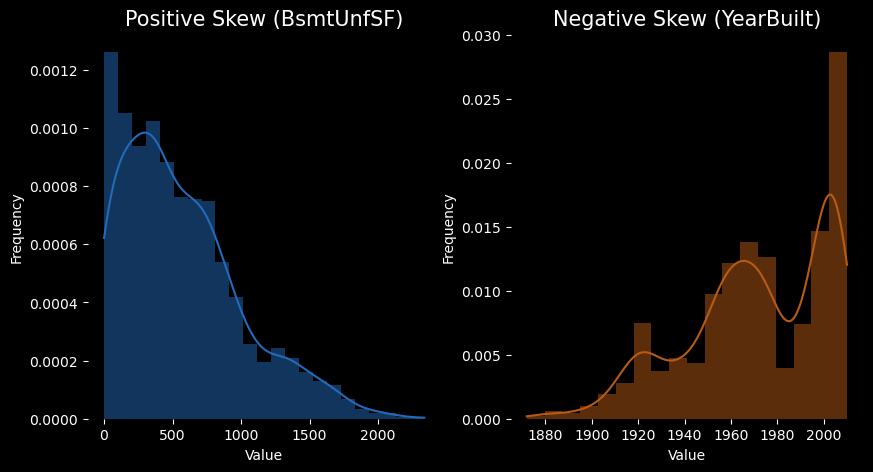

In [34]:
# Data Partition and Transformation (Visualization)
fig, (ax_positive, ax_negative) = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor('black')
ax_positive.patch.set_facecolor('black')
ax_negative.patch.set_facecolor('black')

sns.histplot(data_modelling['BsmtUnfSF'],kde=True, stat='density', linewidth=0, color = '#236AB9', ax=ax_positive)
sns.histplot(data_modelling['YearBuilt'], kde=True, stat='density', linewidth=0,color='#B85B14', ax=ax_negative)

ax_positive.tick_params(axis='x', colors='white')
ax_positive.tick_params(axis='y', colors='white')
ax_negative.tick_params(axis='x', colors='white')
ax_negative.tick_params(axis='y', colors='white')

ax_positive.set(ylabel='Frequency', xlabel='Value');
ax_negative.set(ylabel='Frequency', xlabel='Value');

ax_positive.xaxis.label.set_color('white')
ax_positive.yaxis.label.set_color('white')
ax_negative.xaxis.label.set_color('white')
ax_negative.yaxis.label.set_color('white')

ax_positive.set_title('Positive Skew (BsmtUnfSF)', color='white', fontsize= 15)
ax_negative.set_title('Negative Skew (YearBuilt)', color='white', fontsize= 15)

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax_positive.spines[i].set_visible(False)

for i in ['top', 'bottom', 'left', 'right']:
    ax_negative.spines[i].set_visible(False)

In [35]:
# Data Partition and Transformation (BoxCox Transformation)
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Normalize skewed features without SalePrice column using boxcox1p

for col in skew_cols.index:
    if col != "SalePrice":
        try:
            data_modelling[col] = boxcox1p(data_modelling[col], boxcox_normmax(data_modelling[col] + 1))
        except:
            print(f'column {col} cannot apply boxcox1p')
            continue

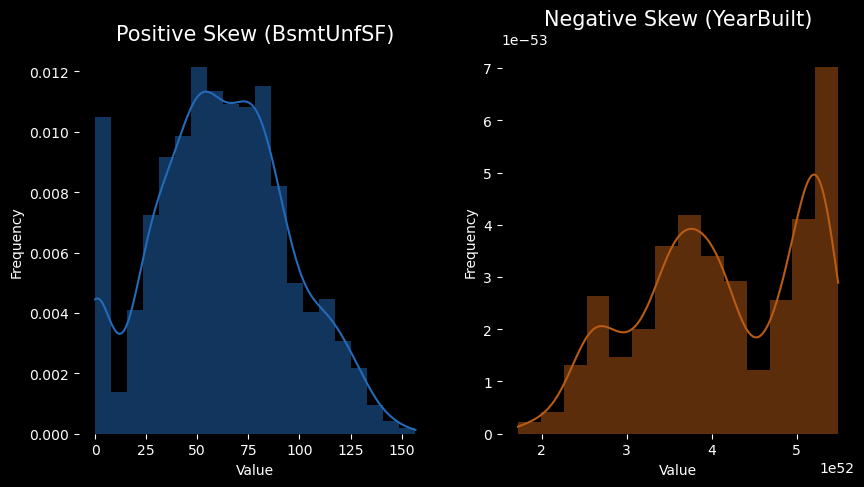

In [36]:
# Data Partition and Transformation (Visualization)
fig, (ax_positive, ax_negative) = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor('black')
ax_positive.patch.set_facecolor('black')
ax_negative.patch.set_facecolor('black')

sns.histplot(data_modelling['BsmtUnfSF'],kde=True, stat='density', linewidth=0, color = '#236AB9', ax=ax_positive)
sns.histplot(data_modelling['YearBuilt'], kde=True, stat='density', linewidth=0,color='#B85B14', ax=ax_negative)

ax_positive.tick_params(axis='x', colors='white')
ax_positive.tick_params(axis='y', colors='white')
ax_negative.tick_params(axis='x', colors='white')
ax_negative.tick_params(axis='y', colors='white')

ax_positive.set(ylabel='Frequency', xlabel='Value');
ax_negative.set(ylabel='Frequency', xlabel='Value');

ax_positive.xaxis.label.set_color('white')
ax_positive.yaxis.label.set_color('white')
ax_negative.xaxis.label.set_color('white')
ax_negative.yaxis.label.set_color('white')

ax_positive.set_title('Positive Skew (BsmtUnfSF)', color='white', fontsize= 15)
ax_negative.set_title('Negative Skew (YearBuilt)', color='white', fontsize= 15)

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax_positive.spines[i].set_visible(False)

for i in ['top', 'bottom', 'left', 'right']:
    ax_negative.spines[i].set_visible(False)

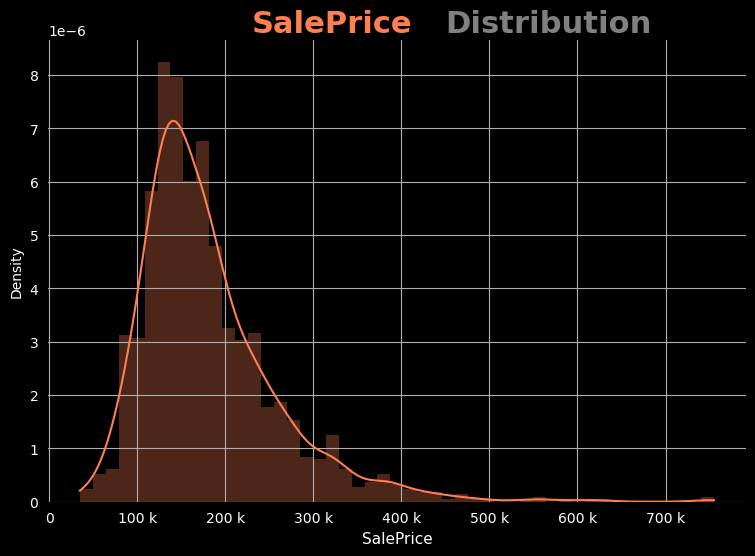

In [37]:
# Data Partition and Transformation (Target Transformation)
import matplotlib.ticker as ticker
# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')

sns.histplot(data_modelling['SalePrice'], stat='density', linewidth=0, color = '#ff7f50', kde=True, alpha=0.3);

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.xaxis.set_major_formatter(ticker.EngFormatter())

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

plt.xlabel('SalePrice', fontsize=11);

plt.text(230000, 0.0000088, "SalePrice", size=22, color="#ff7f50", fontweight="bold");
plt.text(450000, 0.0000088, "Distribution", size=22, color="grey", fontweight="bold");

In [38]:
# Data Partition and Transformation (Target Transformation) log(1+x) transform
data_modelling["SalePrice"] = np.log1p(data_modelling["SalePrice"])

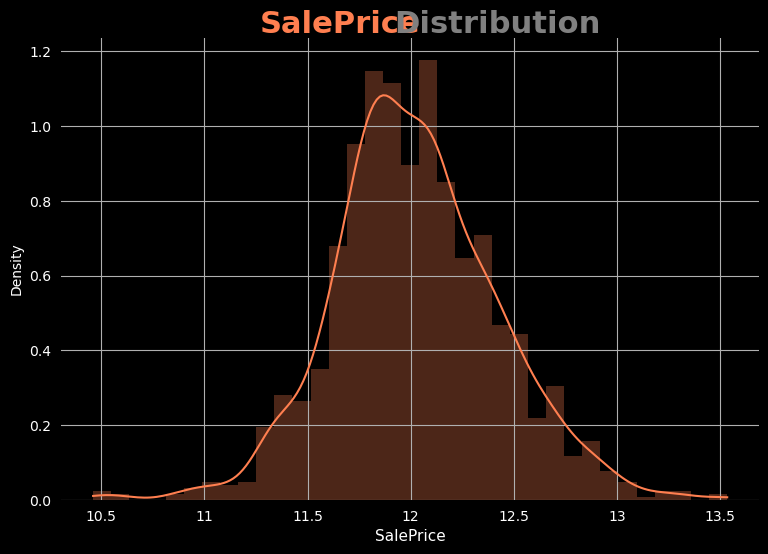

In [39]:
# Data Partition and Transformation (Target Transformation) Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')

sns.histplot(data_modelling['SalePrice'], stat='density', linewidth=0, color = '#ff7f50', kde=True, alpha=0.3);

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.xaxis.set_major_formatter(ticker.EngFormatter())

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
plt.xlabel('SalePrice', fontsize=11);

plt.text(11.27, 1.25, "SalePrice", size=22, color="#ff7f50", fontweight="bold");
plt.text(11.92, 1.25, "Distribution", size=22, color="grey", fontweight="bold");

In [40]:
# Modelling
data_modeling = data_modelling.copy()

# Encoder
for col in categoric_cols:
    ord_encoder = OrdinalEncoder()
    data_modeling[col] = ord_encoder.fit_transform(
        data_modeling[col].values.reshape(-1, 1)
    )


In [41]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


y = data_modeling["SalePrice"]
X = data_modeling.drop(["SalePrice"], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345
)

# Model
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))


RMSE:  0.1934519952285089
